In [57]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from skimage.morphology import erosion, dilation,binary_erosion, opening, disk, closing
import skimage
import cv2

from skimage.filters.rank import entropy, median
from skimage.filters import threshold_otsu
from skimage import filters
from skimage import morphology

from skimage.morphology import thin
from skimage import io, filters
from tp2 import my_segmentation, evaluate
from skimage import exposure
from scipy.fft import fft2, fftshift
from scipy.signal import convolve2d

from skimage import segmentation

from skimage.morphology import thin
from skimage.filters import frangi, hessian

import scipy

## Exploring data + code

Accuracy = 0.14429232549170845, Recall = 0.8434400360685302


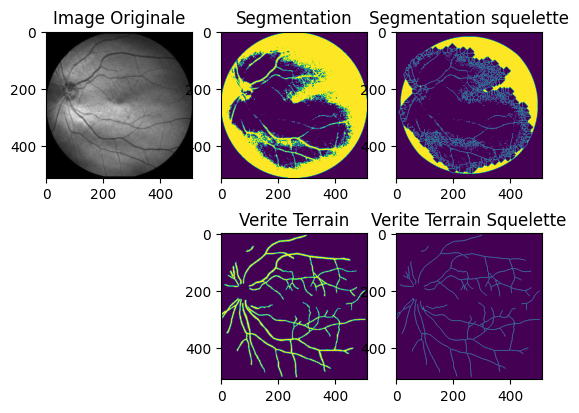

In [2]:
img =  np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)

nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]

img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows / 2) ** 2 + (col - ncols / 2) ** 2 > (nrows / 2) ** 2)
img_mask[invalid_pixels] = 0

img_out = my_segmentation(img, img_mask, 85)

img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

evaluate(img_out, img_GT)

img_out_skel = thin(img_out, max_num_iter = 15)
GT_skel = thin(img_GT, max_num_iter = 15)

plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
##################################
plt.subplot(232)
plt.imshow(img_out)
plt.title('Segmentation')
##################################
plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')
##################################
plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')
##################################
plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()

Accuracy = 0.10056818181818182, Recall = 0.06584821428571429


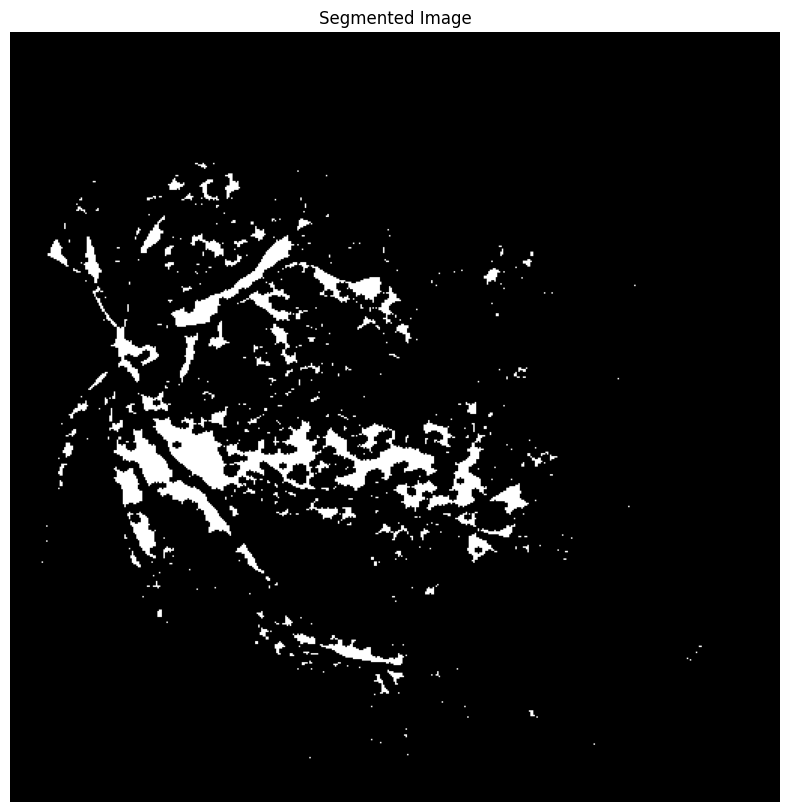

In [3]:
# Charger l'image
image = cv2.imread('./images_IOSTAR/star01_OSC.jpg', 0)  
# image en niveaux de gris

# Prétraitement de l'image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
preprocessed_image = clahe.apply(image)

# Filtrage pour détecter les vaisseaux sanguins
vessel_image = cv2.morphologyEx(preprocessed_image, cv2.MORPH_TOPHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)))

# Binarisation
ret, binary_image = cv2.threshold(vessel_image, 60, 255, cv2.THRESH_BINARY)

# Post-traitement
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

evaluate(binary_image, img_GT)

# Afficher l'image segmentée
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.show()


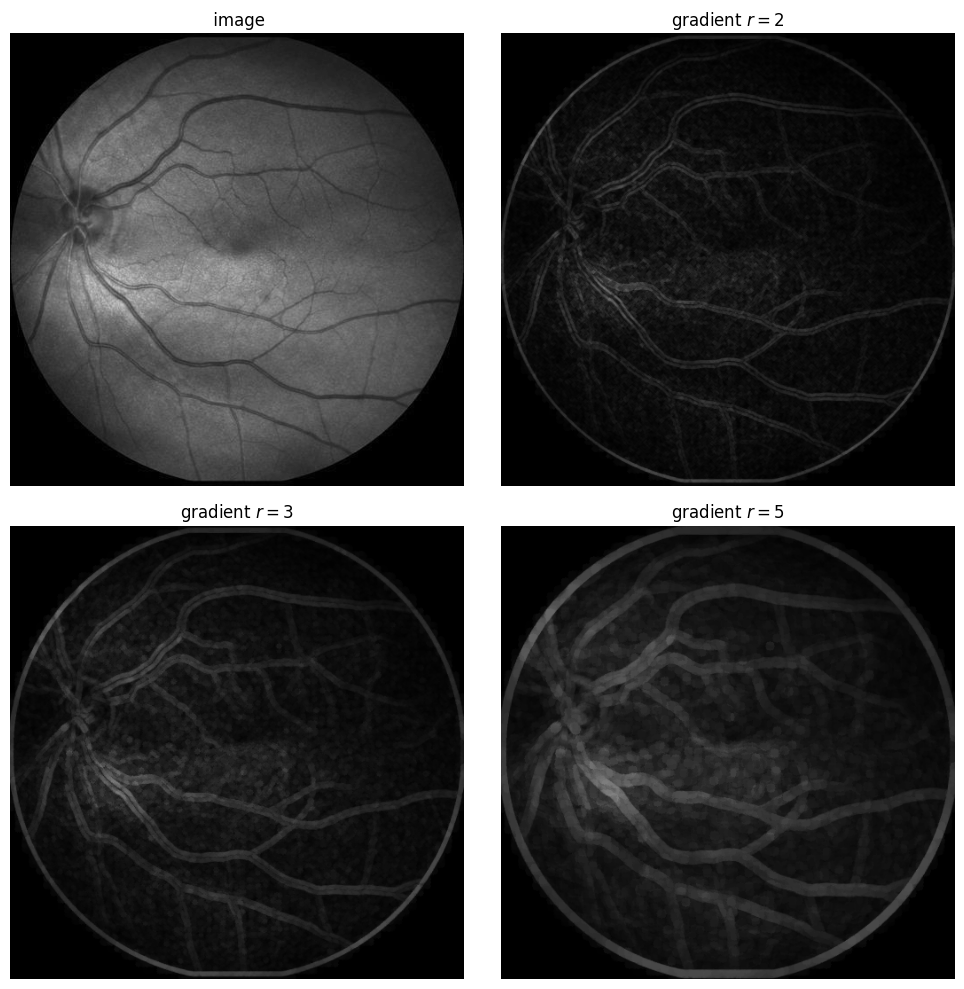

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title(' image')

ax[1].imshow(dilation(image, disk(2)) -erosion(image, disk(2)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('gradient $r=2$')

ax[2].imshow(dilation(image, disk(3))-erosion(image, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('gradient $r=3$')

ax[3].imshow(dilation(image, disk(5))-erosion(image, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('gradient $r=5$')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Simulating algorithm

In [5]:
original_image =  np.array(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)

## Matched-filter response

### First possible filter

Accuracy = 0.13005214441279947, Recall = 0.9025542273734695


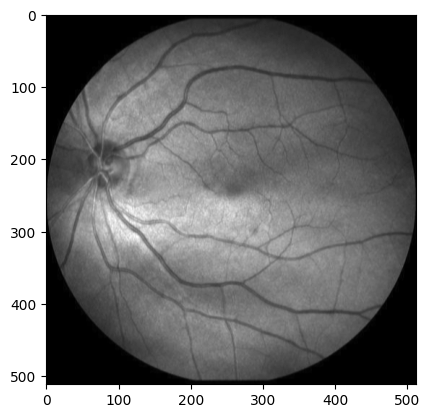

In [6]:
def matched_filter(image, kernel):
    # Convolve the image with the matched filter kernel
    return cv2.filter2D(image, -1, kernel)

gabor_kernel = cv2.getGaborKernel((15, 15), 7, np.pi/3, 6, 0.3) # Testing Gabor filter
gaussian_kernel = cv2.getGaussianKernel(30, np.pi/3) # Testing Gaussian filter

image_with_kernel = matched_filter(original_image, gaussian_kernel)

evaluate(image_with_kernel, img_GT)

plt.imshow(image_with_kernel, cmap = 'gray')

In [7]:
# Function to calculate contrast. The filter (first step of algo) tries to increase contrast in image. With this
# function we could calculate different parameters, filters, etc and compare results with one result.

# To explore also Michelson contrast
def calculate_contrast(image):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0,256])

    # Normalize histogram
    hist /= hist.sum()

    # Calculate mean intensity
    mean_intensity = np.sum(np.arange(256) * hist[:,0])

    # Calculate contrast (standard deviation of intensities)
    contrast = np.sqrt(np.sum(((np.arange(256) - mean_intensity) ** 2) * hist[:,0]))

    return contrast
    

### Second possible filter

42.469777583749234 74.44118638443294


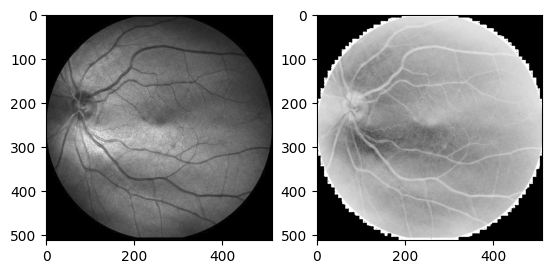

In [8]:
def generate_matched_filter_kernels(alpha, L):
    kernels = []
    for angle in range(0, 180, 15):  # Rotate the kernel in 15-degree increments
        kernel = np.zeros((15, 15))
        x_shape = kernel.shape[0]
        y_shape = kernel.shape[1]
        for x in range(x_shape):
            for y in range(y_shape):
                # Rotate the coordinates
                x_rotated = (x - x_shape / 2) * np.cos(np.radians(angle)) + (y - y_shape / 2) * np.sin(np.radians(angle))
                y_rotated = -(x - x_shape / 2) * np.sin(np.radians(angle)) + (y - y_shape / 2) * np.cos(np.radians(angle))
                # Calculate the kernel value based on the prototype formula
                if abs(y_rotated) <= L / 2:
                    kernel[y, x] = -np.exp(-x_rotated ** 2 / (2 * alpha ** 2))
        kernel /= np.sum(np.abs(kernel))  # To normalize kernels
        kernel = np.asanyarray(kernel, np.float32)
        kernels.append(kernel)
    return kernels

def apply_matched_filter_kernels(image, kernels):
    responses = []
    for kernel in kernels:
        # response = cv2.filter2D(image, -1, kernel) # cv2 library doesn't work very well with kernels
        response = scipy.ndimage.convolve(image, kernel)
        # yield response
        responses.append(response)
    return np.max(responses, axis=0)

alpha = np.pi / 6  # Adjust as needed
L = 1      # Length of the segment for vessel orientation

# Generate matched filter kernels
kernels = generate_matched_filter_kernels(alpha, L)

# Apply the matched filter kernels
filtered_image = apply_matched_filter_kernels(original_image, kernels)
# for result in apply_matched_filter_kernels(original_image, kernels):

cont_or = calculate_contrast(original_image)
cont_ker = calculate_contrast(filtered_image) # the contrast is higher than in the original picture
print(cont_or, cont_ker)

plt.subplot(1, 2, 1)  
plt.imshow(original_image, cmap = 'gray')

plt.subplot(1, 2, 2)  
plt.imshow(filtered_image, cmap = 'gray')
plt.show()


## Local Entropy Thresholding

In [9]:
def local_entropy_threshold(image, window_size):
    height, width = image.shape[:2]
    entropy_image = np.zeros((height, width))

    # Iterate over each pixel in the image
    for y in range(height):
        for x in range(width):
            # Define the local window
            x_min = max(0, x - window_size // 2)
            x_max = min(width, x + window_size // 2)
            y_min = max(0, y - window_size // 2)
            y_max = min(height, y + window_size // 2)

            # Extract the local region
            local_region = image[y_min:y_max, x_min:x_max]

            # Compute the histogram
            hist, _ = np.histogram(local_region.flatten(), bins=256, range=[0, 256])

            # Compute probability distribution
            prob_dist = hist / np.sum(hist)

            # Compute entropy
            entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10))  # Adding small value to avoid log(0)

            # Assign entropy to the corresponding pixel
            entropy_image[y, x] = entropy

    return entropy_image

In [10]:
entropy_image = local_entropy_threshold(original_image, 5)

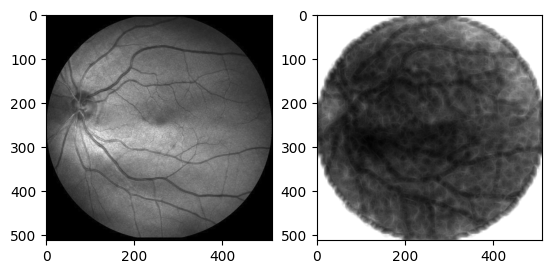

In [11]:
alpha = np.pi / 6  # Adjust as needed
L = 40      # Length of the segment for vessel orientation

# Generate matched filter kernels
kernels = generate_matched_filter_kernels(alpha, L)

# Apply the matched filter kernels
filtered_image = apply_matched_filter_kernels(entropy_image, kernels)
plt.subplot(1, 2, 1)  
plt.imshow(original_image, cmap = 'gray')

plt.subplot(1, 2, 2)  
plt.imshow(filtered_image, cmap = 'gray')
plt.show()

In [12]:
_, binary_image = cv2.threshold(entropy_image, 0, 255, cv2.THRESH_BINARY)

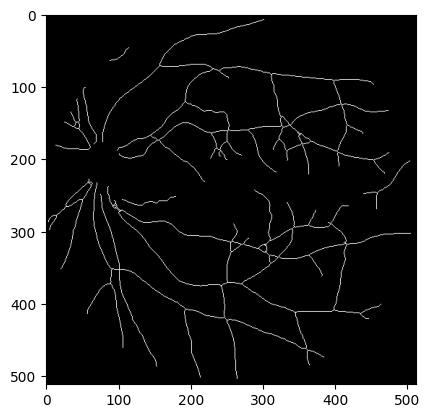

In [13]:
plt.imshow(thin(img_GT, max_num_iter=15), cmap = 'gray')

Accuracy = 0.1336081649434132, Recall = 0.9670647846543612


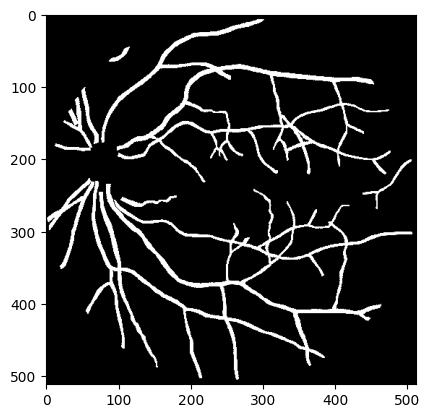

In [14]:
evaluate(entropy_image.astype(np.uint8), img_GT)
plt.imshow(img_GT, cmap = 'gray')

## Testing

In [15]:
def plot_result_image(result_image):
    '''
        Function to plot original image, image to compare and output.
    '''

    f, axs = plt.subplots(1, 3, figsize=(15, 15))

    plt.subplot(1, 3, 1)  
    plt.imshow(original_image, cmap = 'gray')
    plt.title("Original")

    plt.subplot(1, 3, 2)  
    plt.imshow(img_GT, cmap = 'gray')
    plt.title('Verite Terrain')

    plt.subplot(1, 3, 3)  
    plt.imshow(result_image, cmap = 'gray')
    plt.title("Result Image")

    plt.show()

### Testing openings

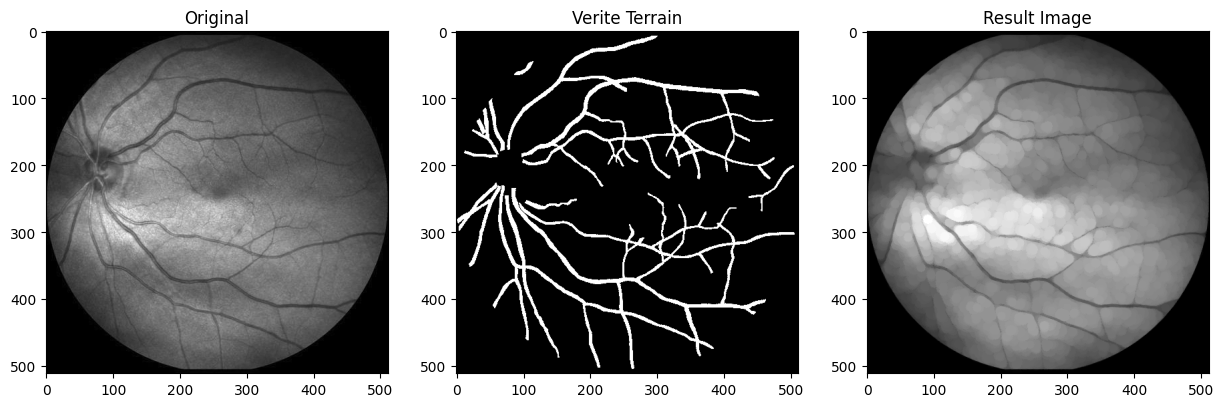

42.469777583749234 38.34034229407218


In [16]:
result = opening(original_image, disk(6))
plot_result_image(result)

cont_or = calculate_contrast(original_image)
cont_ker = calculate_contrast(opening(original_image, disk(6))) # the contrast is lower than in the original picture
print(cont_or, cont_ker)


### Increase contrast

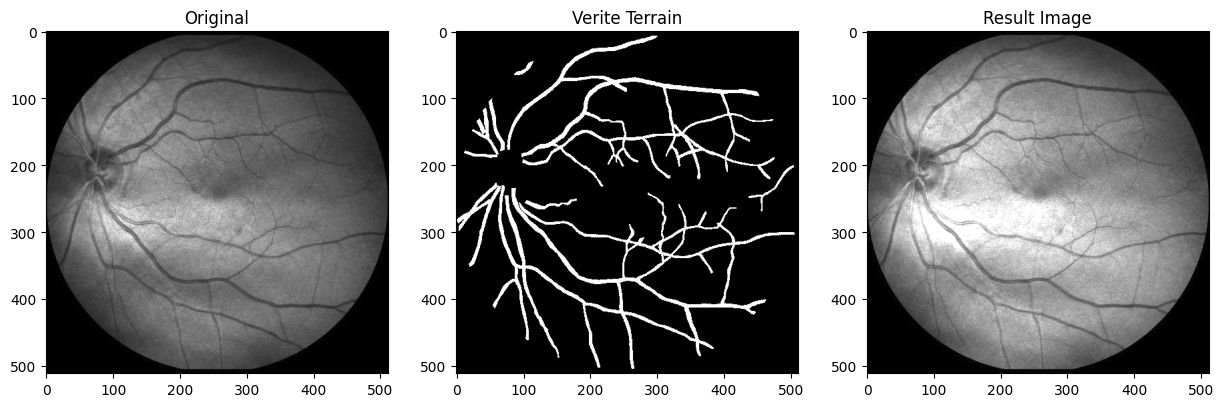

In [17]:
# Contrast stretching
p2, p98 = np.percentile(original_image, (15, 98))
img_rescale_1 = exposure.rescale_intensity(original_image, in_range=(p2, p98)) # read the documentation of rescale_intensity

plot_result_image(img_rescale_1)


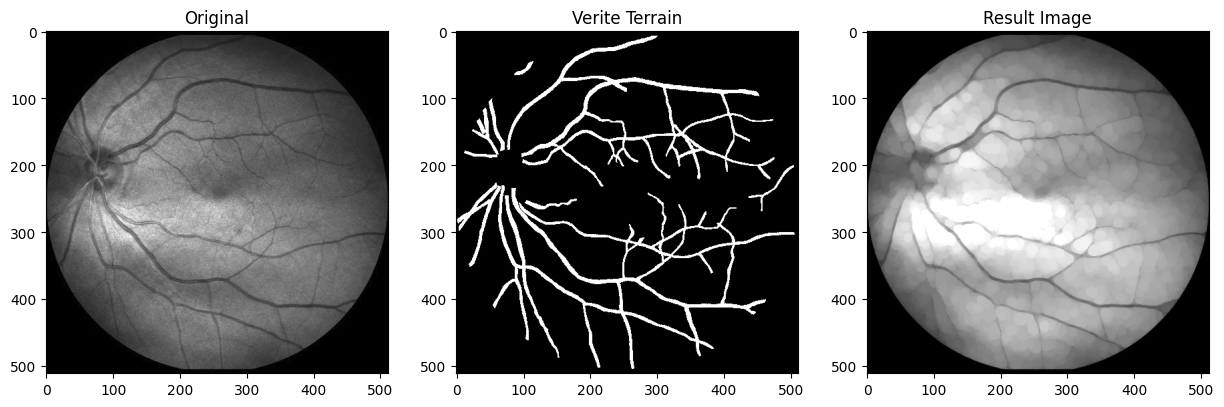

In [18]:
# Contrast stretching
p2, p98 = np.percentile(result, (15, 96))
img_rescale_2 = exposure.rescale_intensity(result, in_range=(p2, p98)) # read the documentation of rescale_intensity

plot_result_image(img_rescale_2)

### Testing butterworth filter (high pass filter)

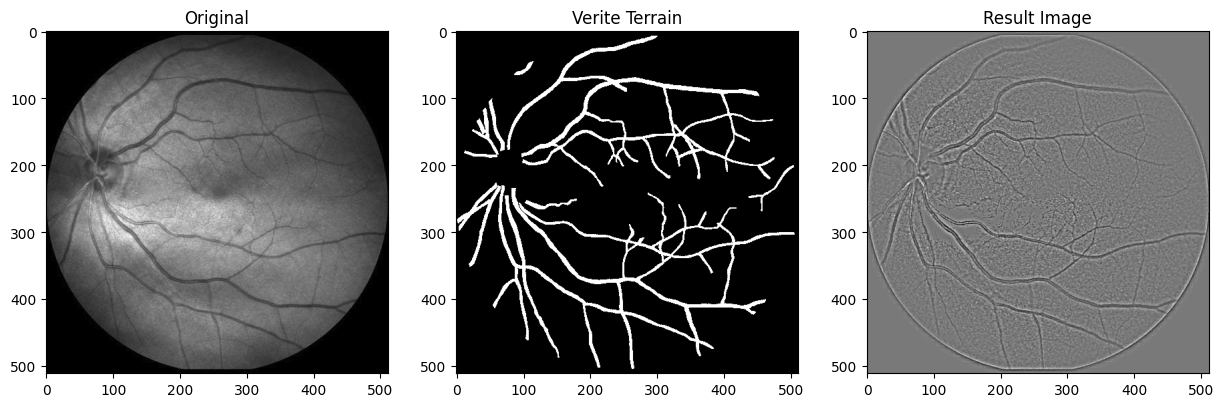

In [19]:
butterworth = filters.butterworth(img_rescale_1, cutoff_frequency_ratio=0.08, high_pass=True)

plot_result_image(butterworth)

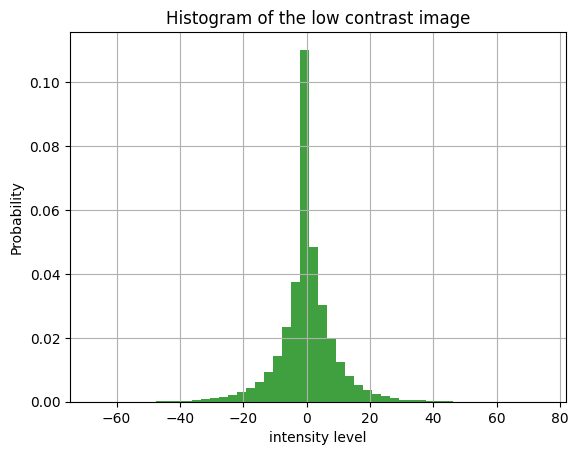

In [20]:
# Checking histogram of butterworth

n, bins, patches = plt.hist(butterworth.ravel(), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('intensity level')
plt.ylabel('Probability')
plt.title('Histogram of the low contrast image')
plt.grid(True)
plt.show()

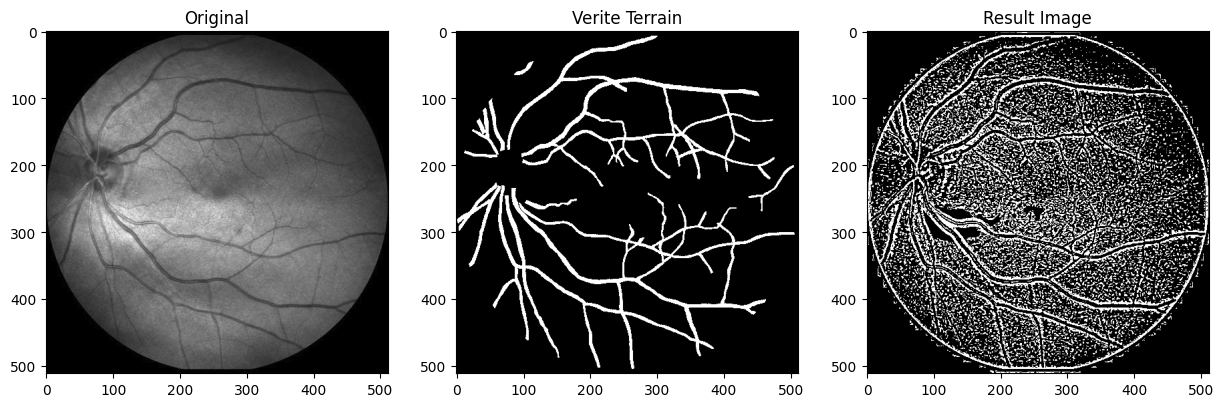

In [21]:
# Trying to convert into a more black/white image

threshold =  np.quantile(butterworth.ravel(), 0.75)
thresholded_image = np.where(butterworth > threshold, 255, 0).astype(np.uint8)

plot_result_image(thresholded_image)

### Closing

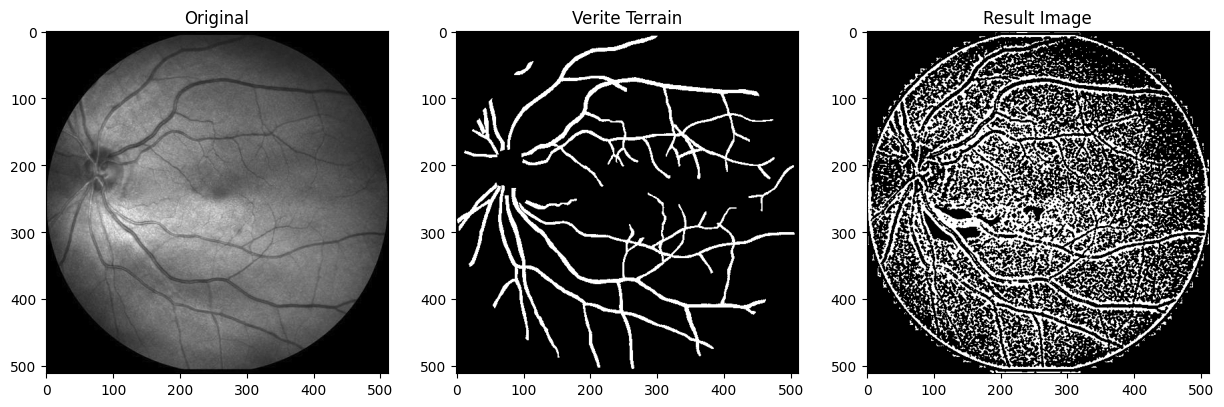

In [22]:
# With closing
closed_image = closing(thresholded_image, disk(1))
plot_result_image(closed_image)

### Threshold_li filter

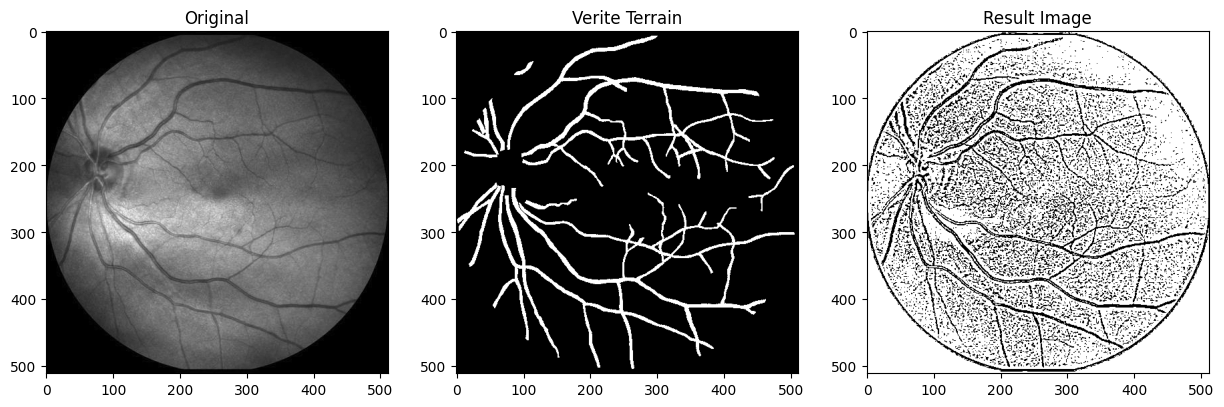

In [23]:
threshold_li = filters.threshold_li(butterworth)
binary = butterworth > threshold_li

plot_result_image(binary)

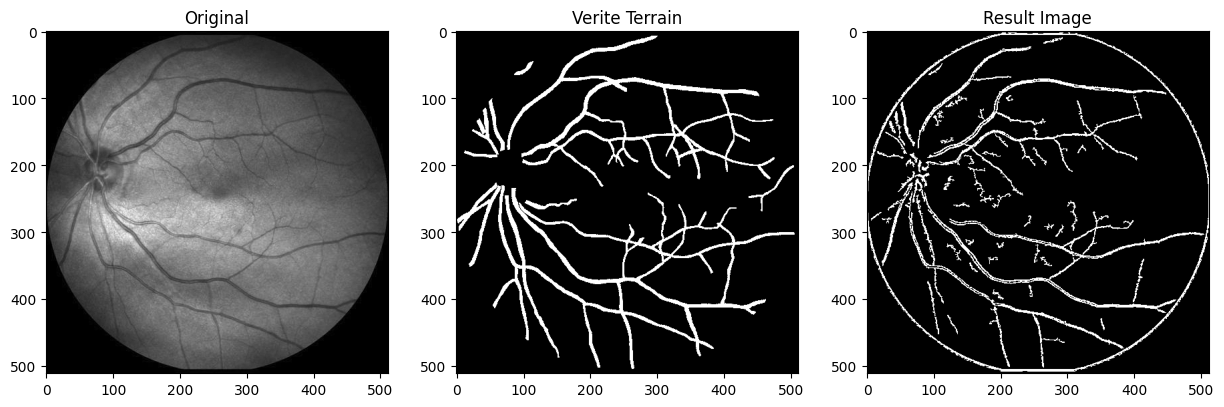

Accuracy = 0.11027702691069369, Recall = 0.920655454937473


In [56]:
removed_small_holes = morphology.remove_small_holes(binary, area_threshold=40)
# Invert the binary image if needed (vessels are white on black background)
binary_image = cv2.bitwise_not(removed_small_holes.astype(np.uint8))
plot_result_image(binary_image)
evaluate(binary_image.astype(np.uint8), img_GT)

### Testing measure.label filters

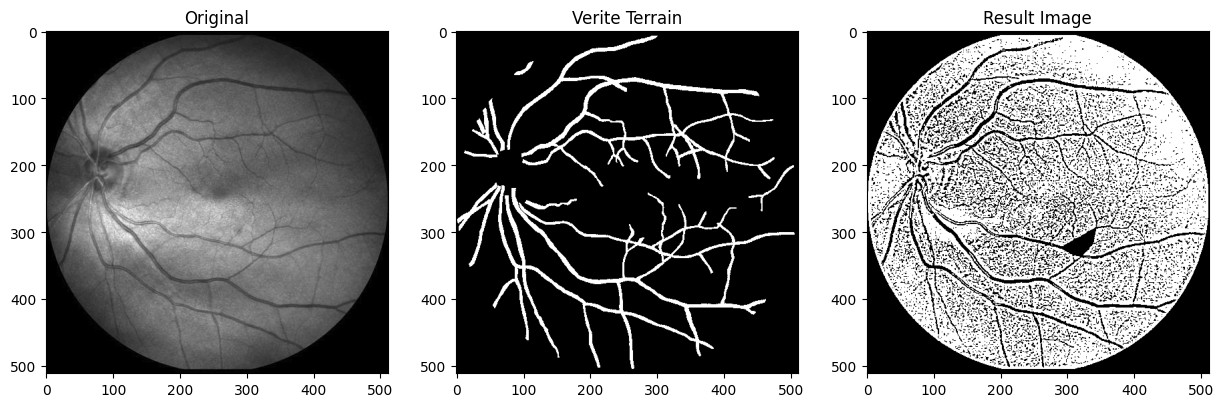

In [25]:
labels = skimage.measure.label(binary,background=100, connectivity=2)

# Get the unique labels and their sizes
unique_labels, label_sizes = np.unique(labels, return_counts=True)

# Filter out components with fewer pixels than the threshold (e.g., 250)
threshold = 60000
valid_labels = unique_labels[label_sizes >= threshold]

# Create a new binary image with only the valid components
new_filtered_image = np.zeros_like(binary)
for label in valid_labels:
    new_filtered_image[labels == label] = 255 

plot_result_image(new_filtered_image)

### Trying with morphology.remove_small_objects

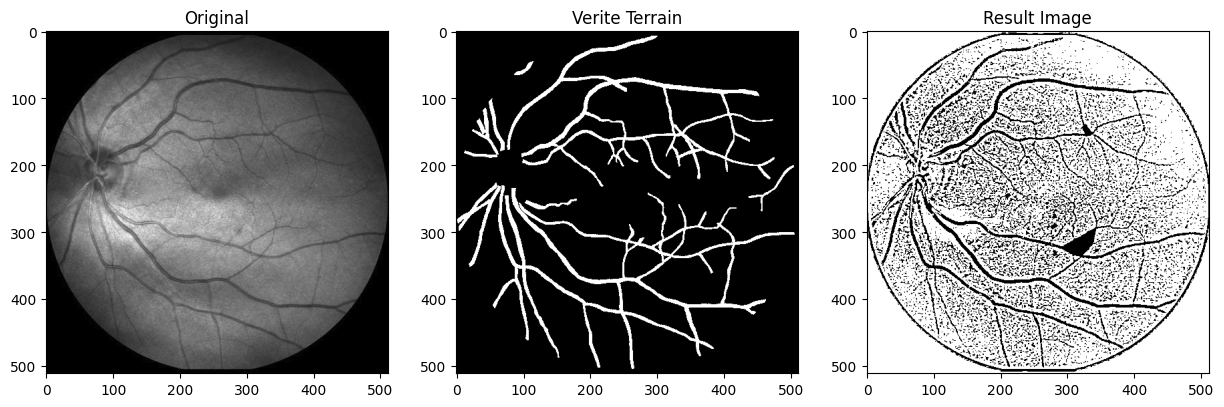

In [26]:
threshold_value = 0.4  # Adjust as needed
binary_image = binary > threshold_value

# Remove small black points or noise
min_size = 1000  # Adjust as needed
cleaned_image = morphology.remove_small_objects(binary_image, min_size=min_size)

plot_result_image(cleaned_image)

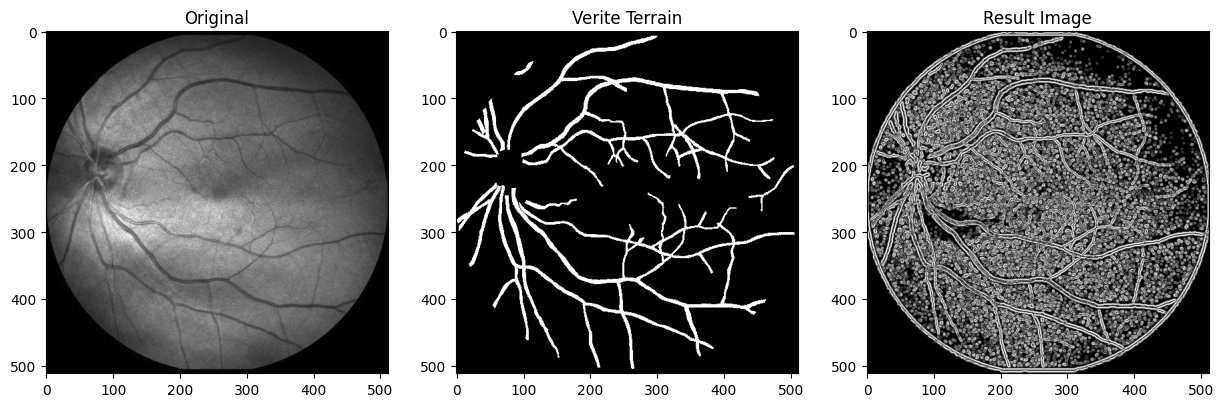

In [27]:
edges = filters.farid(binary)
plot_result_image(edges)

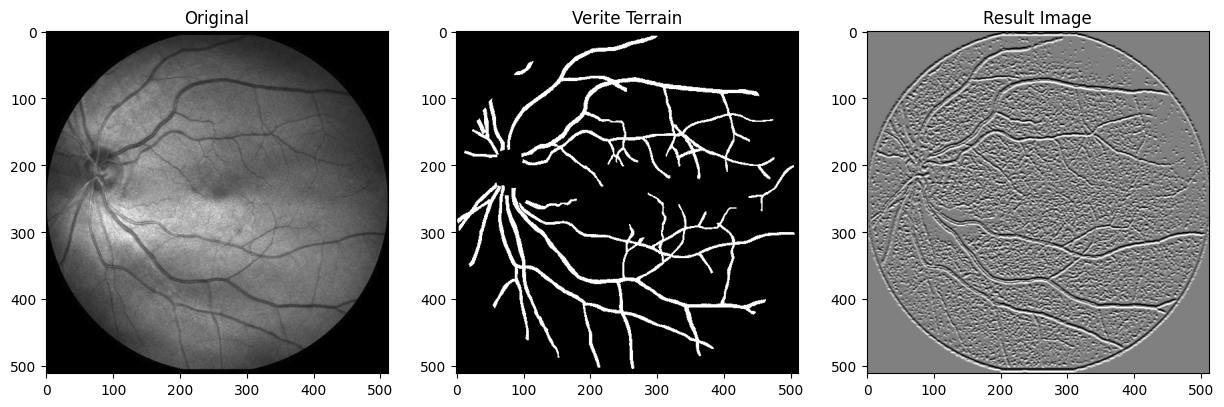

In [28]:
edges = filters.farid_h(binary)
plot_result_image(edges)

/var/folders/0j/5lhv1myn73b7bt9349jt598r0000gn/T/ipykernel_91066/2081362247.py:18: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, _ = np.histogram(local_region.flatten(), bins=256, range=[0, 256])


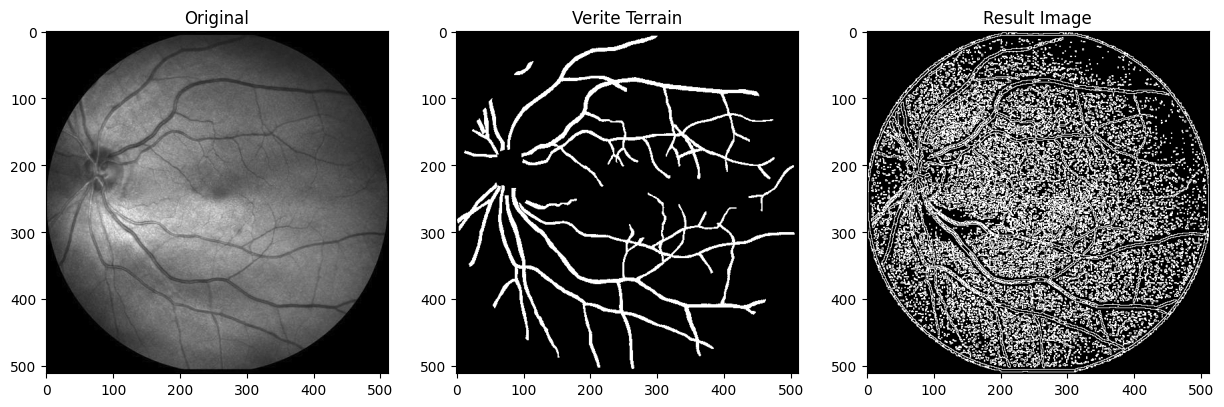

In [29]:
entropy_image = local_entropy_threshold(binary, 2)
_, binary_image = cv2.threshold(entropy_image, 0, 255, cv2.THRESH_BINARY)
plot_result_image(binary_image)

In [30]:
def contrasted_watershed(grad, threshold=0.01):
    # description
    # this code will calculate watershed of the most constrasted area
    # input :image gradient
    # input :contrast of the local minima that we discard
    # output : labels_waterhed an image with a label by cluster
    grad = grad - np.amin(grad)
    grad = grad / np.amax(grad)
    local_minima = morphology.extrema.h_minima(grad, threshold)
    #Image.fromarray(255 * local_minima).show('local minima')

    seeds = label(local_minima)#, neighbors=4)

    #local_minima = local_minima.astype(np.uint8)
    labels_waterhed = morphology.watershed(grad, seeds)
    return labels_waterhed

In [31]:
gradient = dilation(image, disk(3))-erosion(image, disk(3))
labels_waterhed = contrasted_watershed(gradient, threshold=0.1)
plot_result_image(labels_waterhed)

TypeError: 'numpy.int32' object is not callable

### Example

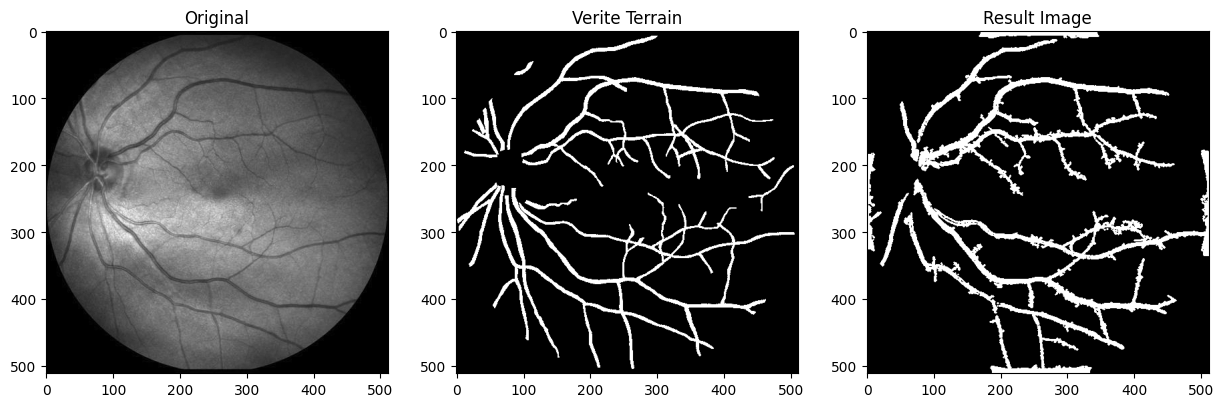

Accuracy = 0.664977192093259, Recall = 0.7202195791399817


In [58]:
test_image = cv2.imread('./images_IOSTAR/star01_OSC.jpg', 1)

 #test image is converted to LAB modal
lab = cv2.cvtColor(test_image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

#Contrast Limited Adaptive Histogram Equalization is applied
clahe = cv2.createCLAHE(clipLimit=3.0)
cl = clahe.apply(l)
limg = cv2.merge((cl, a, b))

#LAB modal converted back to RGB
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

#applying alternate sequential filtering
blue,green,red = cv2.split(final)
r1 = cv2.morphologyEx(green, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
f4 = cv2.subtract(R3, green)
f5 = clahe.apply(f4)

#tophat morphological transformation
image1 = f5
e_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
closeImg = cv2.morphologyEx(image1, cv2.MORPH_CLOSE, e_kernel)
revImg = closeImg
topHat = image1 - revImg

#otsu with probability and minimization function
imge = topHat
blur = cv2.GaussianBlur(imge, (5,5), 0)
hist = cv2.calcHist([blur], [0], None, [256], [0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()
bins = np.arange(256)
fn_min = np.inf
thresh = -1
for i in range(1, 256):
    p1, p2 = np.hsplit(hist_norm, [i]) #probabilities
    q1, q2 = Q[i],Q[255]-Q[i] #cum sum of classes
    b1, b2 = np.hsplit(bins,[i]) #weights

#finding means and variances
if q1 == 0:
    q1 = 0.0000001
if q2 == 0:
    q2 = 0.0000001
m1, m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
v1, v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

#calculates the minimization function
fn = v1*q1 + v2*q2
if fn < fn_min:
    fn_min = fn
    thresh = i

#find otsu&'s threshold value with OpenCV function
ret, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#removing very small contours through area parameter noise removal
ret, f6 = cv2.threshold(f5, 15, 255, cv2.THRESH_BINARY)

mask = np.ones(f5.shape[:2], dtype='uint8') * 255
contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if cv2.contourArea(cnt) <= 255:
        cv2.drawContours(mask, [cnt], -1, 0, -1)
im = cv2.bitwise_and(f5, f5, mask=mask)
ret, fin = cv2.threshold(im, 15, 255, cv2.THRESH_BINARY_INV)
newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)), iterations=1)

#removing blobs of unwanted size
fundus_eroded = cv2.bitwise_not(newfin)
xmask = np.ones(fundus_eroded.shape[:2], dtype='uint8') * 255
xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for cnt in xcontours:
    shape = 'unidentified'
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
    if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
        shape = 'circle'
    else:
        shape = 'vessels'
    
    if(shape == 'circle'):
        cv2.drawContours(xmask, [cnt], -1, 0, -1)

finimage = cv2.bitwise_and(fundus_eroded, fundus_eroded, mask=xmask)
blood_vessels = cv2.bitwise_not(finimage)
kernel = np.ones((2,2), np.uint8)
blood_vessels = cv2.subtract(255, blood_vessels)

#eroding is done to eliminate the minor noises (post processing)
new = cv2.morphologyEx(blood_vessels, cv2.MORPH_OPEN, kernel)
new1 = cv2.morphologyEx(new, cv2.MORPH_CLOSE, kernel)

plot_result_image(fundus_eroded)
evaluate(fundus_eroded.astype(np.uint8), img_GT)

### Example 2

Reading image...
Extracting mask...
Extracting green channel...
Removing background...
Equalizing histograms...
Extracting veins using hessian...
Using bilateral filter...
Removing noise...
Image processing done.


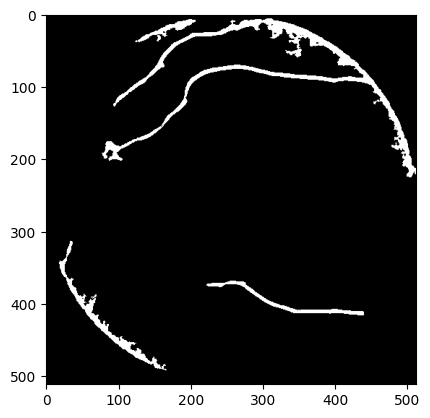

In [41]:
def invert_colors(img):
    '''
    Invert colors in the image.
    :param img: - input image
    :return new_image: - image with inverted colors
    '''
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = abs(255 - img[x][y])
    return new_image


def remove_background(img, mask):
    '''
    Remove background using mask, in other words set pixels to black if the pixel of the
    same coordinates in mask is not black.
    :param img: - input image
    :param mask: - mask image used to remove background
    :return new_image: - image without the background
    '''
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = img[x][y] if mask[x][y] == 0 else 0
    return new_image


# 1. Read image
def read_image(filepath):
    '''
    Standard function to read image
    :param filepath: - image filepath
    :return img: - image as numpy array
    '''
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    # OpenCV 2 reads images in BGR, so we convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# 2. Extract background mask from image
def get_mask(img, threshold = 5):
    '''
    Extract background mask from image by removing pixels above threshold and converting those
    below it to white.
    :param img: - input image
    :param threshold: - the threshold
    :return img_mask: - result mask
    '''
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_mask = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img_mask):
        for y, _ in enumerate(row):
            # Thresholding
            img_mask[x][y] = 255 if img[x][y] < threshold else 0
    return img_mask


# 3. Extract green channel from the image
def get_green_channel(img):
    '''
    Extract green channel from image.
    :param img: - input image
    :return green_img: - result image with only green channel
    '''
    _, green_img, _ = cv2.split(img)
    green_img = invert_colors(green_img)
    return green_img


# 4. Small noise removal
def remove_noise(img, min_size = 600):
    '''
    Remove small dots from image.
    :param img: - input image
    :param min_size: - minimum size of objects to not be removed
    :return clear_img: - image without noise
    '''
    # Detect connected objects in image
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    # Extract sizes
    sizes = stats[1:, -1]
    clear_img = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(0, nb_components - 1):
        # If the object is bigger than min_size, redraw it on output image
        if sizes[i] >= min_size:
            clear_img[output == i + 1] = 255
    return clear_img


# 5. Remove big circle around retina
def remove_retina_circle(img, base_offset=2000):
    '''
    Remove big circle around retina using Hough circles.
    Algorithm will search until it finds one circle of specific size in the image.
    If that is not possible, no changes are made.
    :param img: - input image
    :param base_offset: - start searching from this size (speeds up computation)
    :return no_retina_img: - image without the circle
    '''
    no_retina_img = img.copy()
    circle = np.zeros(img.shape, np.uint8)
    offset = 0
    detections = []
    while True:
        # Detect Hough circles from base_offset + offset size
        detections = cv2.HoughCircles(no_retina_img, cv2.HOUGH_GRADIENT, 1.5, base_offset + offset)
        # Stop if no circles can be detected
        if detections is None:
            return no_retina_img
        # If only one circle is detected, finish the search
        if len(detections[0]) == 1:
            break
        # IOtherwise increase size
        offset += 100
    for (x, y, r) in detections[0]:
        # Draw a circle to be removed
        cv2.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), 40)
    # Circle removal
    no_retina_img = no_retina_img - circle
    return no_retina_img

def detect_veins(filepath):
    '''
    Function that merges the functionality above.
    :param filepath: - input image path
    '''
    print("Reading image...")
    img = read_image(filepath)
    print("Extracting mask...")
    img_mask = get_mask(img)
    print("Extracting green channel...")
    img = get_green_channel(img)
    print("Removing background...")
    bck_img = remove_background(img, img_mask)
    print("Equalizing histograms...")
    eq_img = cv2.equalizeHist(bck_img)
    print("Extracting veins using hessian...")
    hes_img = hessian(eq_img)
    veins = remove_background(hes_img, img_mask)
    print("Using bilateral filter...")
    filtered_img = cv2.bilateralFilter(veins,11,75,75)
    print("Removing noise...")
    clear_img = remove_noise(filtered_img)
    # print("Removing retina's circle...")
    # result = remove_retina_circle(clear_img)
    print("Image processing done.")
    return clear_img

veins = detect_veins('./images_IOSTAR/star01_OSC.jpg')
plt.imshow(veins, cmap='gray')
plt.show()

### Example 3

In [ ]:
def top_hat(image, openingRadius):

  opening_kernel = morphology.disk(openingRadius)

  openedImage=morphology.opening(image, opening_kernel)

  return image-openedImage
  
def farko_method(data):
    image = cv2.imread(data[0])
    imageGreen = image[:, :, 1]
    # Create mask if not available
    # mask=image[:,:,1]>=20
    # mask=mask.astype(int)
    # print(data)

    maskImg = read_gif(data[1])
    maskImg = cv2.cvtColor(maskImg, cv2.COLOR_BGR2GRAY) / 255

    erosionKernel = morphology.disk(3)

    erodedMask = cv2.erode(maskImg, erosionKernel, iterations=2)

    # cv2_imshow(imageGreen)

    # histogram Eq adaptive
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    clacheImg = clahe.apply(imageGreen)
    # cv2_imshow(clacheImg)

    # Remove black ring
    replaceBlackRing = imageGreen * erodedMask
    meanImage = np.mean(replaceBlackRing)
    replaceBlackRing[replaceBlackRing == 0] = meanImage

    # Top hat
    imgComplement = 255 - replaceBlackRing
    # cv2_imshow(imgComplement)

    topHatedImg = top_hat(imgComplement, 10) * erodedMask
    # cv2_imshow(topHatedImg)
    topHatedImg = topHatedImg.astype('uint8')

    # Otsu
    ret, thresh1 = cv2.threshold(topHatedImg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    thresh1 = thresh1 * erodedMask.astype('uint8')

    # cv2_imshow(thresh1)

    # Cleaning small objects less than 100
    cleaned = morphology.remove_small_objects(thresh1.astype(bool), min_size=100, connectivity=8)

    cleanedImg = cleaned.astype('uint8') * 255

    # cv2_imshow(cleanedImg)

    # is it close the min pixel(backgorund) or to the max pixel(vessel)
    filteredImage = np.abs(imgComplement - imgComplement.max()) < np.abs(imgComplement - meanImage)
    filteredImage = filteredImage.astype('uint8') * cleanedImg
    # cv2_imshow(filteredImage)

    medianCleaned = cv2.medianBlur(cleanedImg, 3)
    # cv2_imshow(medianCleaned)

    filteredImage = cv2.bitwise_or(medianCleaned, filteredImage)
    # filteredImage
    # cv2_imshow(filteredImage)

    # finding thin vessels
    thinVessels = matched_filter(clacheImg, 4, 1, 7, 2.3)

    # cv2_imshow(thinVessels)

    closingKernel = np.ones((3, 3))
    closedThinVessels = morphology.binary_closing(thinVessels, closingKernel)
    # cv2_imshow(closedThinVessels.astype(int)*255)

    cleanedThin = morphology.remove_small_objects(closedThinVessels.astype(bool), min_size=30, connectivity=8)

    # cleanedThin=cleanedThin.astype('uint8')*255
    # cv2_imshow(cleanedThin)

    finalKernael = np.ones((3, 3))
    finalKernael[1, 1] = 0
    finalConv = convolve2d(cleanedThin.astype('uint8'), finalKernael, mode='same')
    finalImage = (finalConv > 0).astype('uint8') * filteredImage.astype('uint8') * erodedMask

    # erodedMask=cv2.erode(erodedMask, erosionKernel, iterations=1)
    finalImage = cv2.bitwise_or(cleanedThin.astype('uint8') * 255, finalImage.astype('uint8')) * erodedMask

    # finalImage=cv2.bitwise_or(cleanedThin.astype('uint8')*255,filteredImage.astype('uint8'))*erodedMask

    # cv2_imshow(finalImage.astype(int))
    return finalImage

In [59]:
5*20*8*5*4*20*8*3*4

30720000